In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["JAX_ENABLE_X64"] = "True"


In [58]:
from functools import partial

from tqdm import tqdm

import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt

from jax import jit as jjit 
from jax import vmap
from jax import grad

from bpd.prior import sample_ellip_prior, shear_transformation, ellip_mag_prior
from bpd.likelihood import shear_loglikelihood, shear_loglikelihood_unreduced
from bpd.pipelines.toy_ellips import pipeline_toy_ellips_samples


In [3]:
g1, g2 = 0.02, 0.02
true_g = jnp.array([g1, g2])

2024-11-25 08:16:25.428298: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
seed = 43
key = random.key(seed)
k1, k2 = random.split(key, 2)

In [37]:
sigma_e=1e-3
sigma_e_int = 4e-2

In [38]:
pipe = jjit(partial(pipeline_toy_ellips_samples, g1=g1, g2 = g2, sigma_e=sigma_e, sigma_e_int=sigma_e_int, sigma_m=1e-5, n_gals=1000, 
                    n_samples_per_gal=100, )
           )

In [39]:
e_post, e_obs, e_sheared = pipe(k1)

In [40]:
# compare std deviations 
e_sheared[:, 0].std(), sigma_e / jnp.sqrt(2), e_obs[:,0].std()

(Array(0.00073002, dtype=float64),
 Array(0.00070711, dtype=float64, weak_type=True),
 Array(0.00072945, dtype=float64))

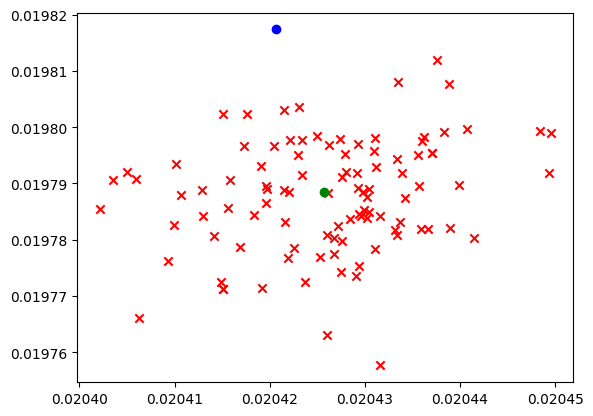

In [41]:
# example (sanity check)
plt.scatter(e_post[0, :, 0], e_post[0, :, 1], marker='x', color='r')
plt.scatter(e_obs[0, 0], e_obs[0, 1], marker='o', color='g')
plt.scatter(e_sheared[0, 0], e_sheared[0, 1], marker='o', color='b')

In [42]:
prior = partial(ellip_mag_prior, sigma=sigma_e)
interim_prior = partial(ellip_mag_prior, sigma=sigma_e_int)
likelihood = jjit(partial(shear_loglikelihood, prior=prior, interim_prior=interim_prior)) 

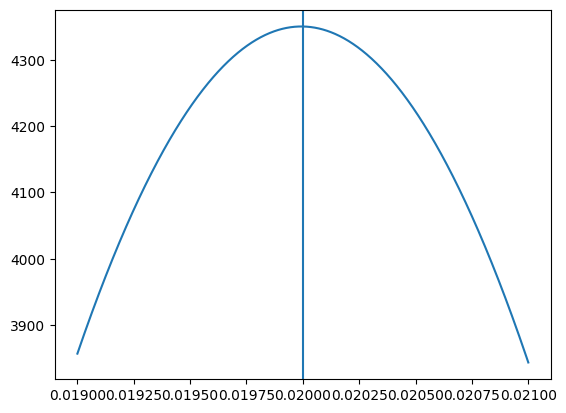

In [44]:
# sanity check
g1s = jnp.linspace(0.019, 0.021, 1000)
gs = jnp.stack([g1s, jnp.full_like(g1s, g2)], axis=-1)
plt.plot(g1s, vmap(likelihood, in_axes=(0, None))(gs, e_post))
plt.axvline(0.02)

In [45]:
# test we can do gradients
grad(likelihood)(true_g, e_post)

Array([ -6663.24033264, -21048.73974422], dtype=float64)

In [46]:
# optax to find maximum point

In [47]:
# get error via Fisher information matrix
grad1 = lambda g, e: grad(likelihood)(g, e)[0]
grad2 = lambda g, e: grad(likelihood)(g, e)[1]

In [48]:
i11, i12 = - grad(grad1)(true_g, e_post)
i21, i22 = - grad(grad2)(true_g, e_post)

In [49]:
inf_mat = jnp.array([[i11, i12], [i21, i22]])
cov = jnp.linalg.inv(inf_mat)

In [50]:
inf_mat, cov

(Array([[ 1.00150751e+09, -3.15040615e+01],
        [-3.15040615e+01,  1.00150998e+09]], dtype=float64),
 Array([[9.98494764e-10, 3.14092132e-17],
        [3.14092132e-17, 9.98492299e-10]], dtype=float64))

In [51]:
1e-3 / jnp.sqrt(1000), jnp.sqrt(cov[0][0]), jnp.sqrt(cov[1][1]), 

(Array(3.16227766e-05, dtype=float64, weak_type=True),
 Array(3.15989678e-05, dtype=float64),
 Array(3.15989288e-05, dtype=float64))

## Plot as a function of number of galaxies

In [99]:
def get_fisher_cov(e_post, true_g, likelihood_fnc):
    grad1 = lambda g, e: grad(likelihood_fnc)(g, e)[0]
    grad2 = lambda g, e: grad(likelihood_fnc)(g, e)[1]
    i11, i12 = - grad(grad1)(true_g, e_post)
    i21, i22 = - grad(grad2)(true_g, e_post)
    inf_mat = jnp.array([[i11, i12], [i21, i22]])
    cov = jnp.linalg.inv(inf_mat)
    return cov

In [142]:
seed = 42
key = random.key(seed)
k1, k2 = random.split(key, 2)


In [143]:
g1, g2 = 0.02, 0.02
true_g = jnp.array([g1, g2])

In [144]:
sigma_e=1e-3
sigma_e_int = 4e-2
sigma_m = 1e-5

In [162]:
pipe = jjit(partial(pipeline_toy_ellips_samples, g1=g1, g2 = g2, 
                    sigma_e=sigma_e, 
                    sigma_e_int=sigma_e_int, 
                    sigma_m=sigma_m, 
                    n_gals=100_000, 
                    n_samples_per_gal=100, 
                   )
           )
e_post, e_obs, e_sheared = pipe(k1)

In [164]:
covs = []

prior = partial(ellip_mag_prior, sigma=sigma_e)
interim_prior = partial(ellip_mag_prior, sigma=sigma_e_int)
likelihood_fnc = jjit(partial(shear_loglikelihood, prior=prior, interim_prior=interim_prior)) 

n_galaxies = (1, 10, 100, 1000, 10_000, 100_000, 1_000_000)

for ii in tqdm(n_galaxies):
    e_samples = e_post[:ii]
    cov = get_fisher_cov(e_samples, true_g, likelihood_fnc)
    covs.append(cov)
    

 86%|████████▌ | 6/7 [00:08<00:01,  1.52s/it]2024-11-25 09:40:30.432411: W external/xla/xla/service/hlo_rematerialization.cc:3005] Can't reduce memory use below -27.33GiB (-29341580634 bytes) by rematerialization; only reduced to 62.04GiB (66610000568 bytes), down from 62.78GiB (67410000568 bytes) originally
2024-11-25 09:40:40.971126: W external/xla/xla/tsl/framework/bfc_allocator.cc:482] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.49GiB (rounded to 1600000000)requested by op 
2024-11-25 09:40:40.971649: W external/xla/xla/tsl/framework/bfc_allocator.cc:494] *************************************************************************************************___
E1125 09:40:40.971670 2296355 pjrt_stream_executor_client.cc:3067] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1600000000 bytes.
 86%|████████▌ | 6/7 [00:19<00:03,  3.21s/it]


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1600000000 bytes.

In [147]:
e_sheared[:, 0].std()

Array(0.00070525, dtype=float64)

In [148]:
# what is actual std of first component?
from bpd.prior import sample_ellip_prior
ellips_unsheared = sample_ellip_prior(k1, sigma=sigma_e, n=100_000)
ellips_unsheared[:, 0].std(), 1e-3 / jnp.sqrt(2)

(Array(0.00070658, dtype=float64),
 Array(0.00070711, dtype=float64, weak_type=True))

Text(0, 0.5, 'Sigma on g1')

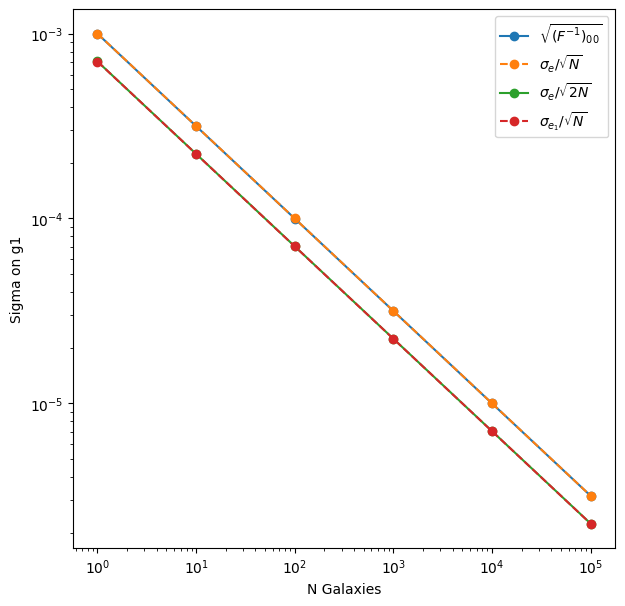

In [149]:
plt.figure(figsize=(7,7))
stds = [jnp.sqrt(cov[0][0]) for cov in covs]


plt.plot(n_galaxies, stds, '-o', label='$\sqrt{(F^{-1})_{00}}$')
plt.plot(n_galaxies, sigma_e / jnp.sqrt(jnp.array(n_galaxies)), '--o', label='$\sigma_{e} / \sqrt{N}$')
plt.xscale('log')

plt.plot(n_galaxies, sigma_e / jnp.sqrt(2 * jnp.array(n_galaxies)), '-o', label='$\sigma_{e} / \sqrt{2N}$')
plt.plot(n_galaxies, ellips_unsheared[:, 0].std() / jnp.sqrt(jnp.array(n_galaxies)), '--o', label='$\sigma_{e_{1}} / \sqrt{N}$')


plt.yscale('log')
plt.legend()
plt.xlabel("N Galaxies")
plt.ylabel("Sigma on g1")

In [150]:
# likelihood_fnc = jjit(partial(shear_loglikelihood, prior=prior, interim_prior=interim_prior)) 
grad_likelihood = grad(likelihood_fnc)

In [151]:
grad_likelihood(true_g, e_post)

Array([  40162.93106463, -263162.55777767], dtype=float64)

In [155]:
# what about mean prediction
import optax
from optax import adam

peak_gs = []

for ii in tqdm(n_galaxies):

    solver = adam(learning_rate=0.003)
    # params = {'g': jnp.array([0.019, 0.019])}
    curr_g = jnp.array([0.019, 0.019])
    opt_state = solver.init(curr_g)


    for _ in range(1000):
        grad_val = -grad_likelihood(curr_g, e_post[:ii])
        updates, opt_state = solver.update(grad_val, opt_state, curr_g)
        curr_g = optax.apply_updates(curr_g, updates)
        
    peak_gs.append(curr_g)
    
    


100%|██████████| 6/6 [00:34<00:00,  5.81s/it]


In [156]:
peak_gs = jnp.array(peak_gs)

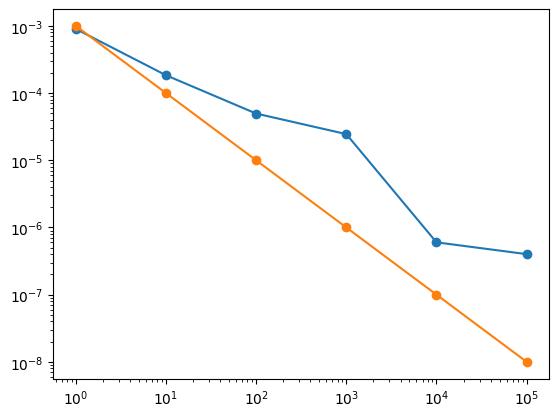

In [161]:
plt.plot(n_galaxies, jnp.abs(peak_gs[:, 0] - 0.02), '-o')
plt.plot(n_galaxies, sigma_e/ jnp.array(n_galaxies), '-o')
plt.xscale('log')
plt.yscale("log")

## Test no noise

In [ ]:
g1, g2 = 0.02, 0.02
true_g = jnp.array([g1, g2])

In [ ]:
seed = 42
key = random.key(seed)
k1, k2 = random.split(key, 2)

In [ ]:
sigma_e=1e-3
sigma_e_int = 4e-2

In [76]:
ellips = sample_ellip_prior(key, sigma=sigma_e, n=1000)
ellips_sheared = shear_transformation(ellips, (g1, g2))
ellips.shape, ellips_sheared.shape

((1000, 2), (1000, 2))

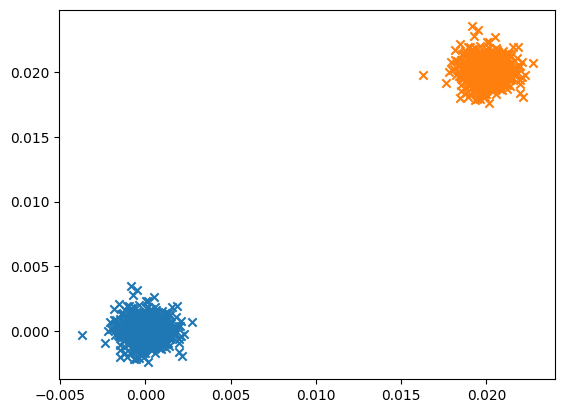

In [77]:
plt.scatter(ellips[:, 0], ellips[:, 1], marker='x')
plt.scatter(ellips_sheared[:, 0], ellips_sheared[:, 1], marker='x')

In [78]:
# # here we assume no observation noise, only 1 sample is needed
# e_post = ellips_sheared.reshape(-1, 1, 2)
# e_post.shape

(1000, 1, 2)

In [79]:
prior = partial(ellip_mag_prior, sigma=sigma_e)
interim_prior = partial(ellip_mag_prior, sigma=sigma_e_int)

In [80]:
# NOTE: what does it mean to use an interim prior when we don't infer from it? 
likelihood = jjit(partial(shear_loglikelihood, prior=prior, interim_prior=interim_prior)) 

In [81]:
# compile
likelihood(true_g, e_post)

Array(-218.62124169, dtype=float64)

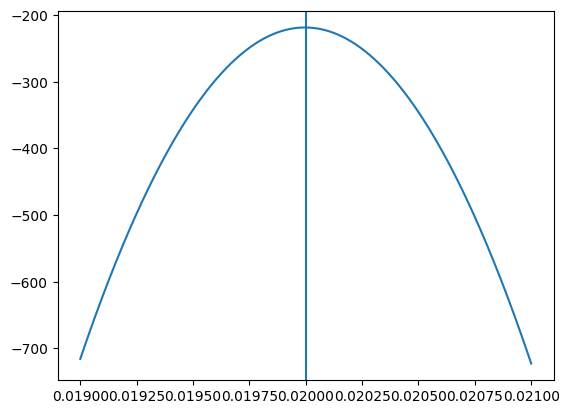

In [82]:
g1s = jnp.linspace(0.019, 0.021, 1000)
gs = jnp.stack([g1s, jnp.full_like(g1s, g2)], axis=-1)
plt.plot(g1s, vmap(likelihood, in_axes=(0, None))(gs, e_post))
plt.axvline(0.02)

In [105]:
likelihood(true_g, e_post)

Array(-218.62124169, dtype=float64)

In [ ]:
# find optimum function using optax

In [98]:
# calculate fisher information matrix to compute std error estimated
grad1 = lambda g, e: grad(likelihood)(g, e)[0]
grad2 = lambda g, e: grad(likelihood)(g, e)[1]

In [103]:
grad(grad1)(jnp.array([0.02, 0.02]), e_post)

Array([nan, nan], dtype=float64)

In [104]:
grad1(true_g, e_post)

Array(nan, dtype=float64)